In [30]:
import warnings
warnings.simplefilter(action='ignore') # , category=FutureWarning)

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

import gridop as gop
import inout as io
import diags as dg
import plot as cplt
from model import Model

In [31]:
from dask.distributed import Client, LocalCluster

# number of cores per node
workers_per_job = 2
# number of nodes
jobs = 4
nworkers = workers_per_job * jobs

# type of cluster
config = 1

if config==1:
    # pour 1 seul noeud
    cluster = LocalCluster(n_workers=4, threads_per_worker=8)
    client = Client(cluster)
else:
    # pour plusieurs noeuds:
    # ** processes and cores may be adjusted in order to have more memory 
    # or inversely more computational ressource
    from dask_jobqueue import PBSCluster
    cluster = PBSCluster(processes=workers_per_job, cores=workers_per_job, walltime='02:00:00')
    w = cluster.scale(jobs=jobs)
    #cluster.adapt(minimum=1, maximum=5)

    client = Client(cluster)

client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:37290/status,
Dashboard: http://127.0.0.1:37290/status,Workers: 4
Total threads: 32,Total memory: 110.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45981,Workers: 4
Dashboard: http://127.0.0.1:37290/status,Total threads: 32
Started: Just now,Total memory: 110.00 GiB
Comm: tcp://127.0.0.1:35390,Total threads: 8
Dashboard: http://127.0.0.1:48213/status,Memory: 27.50 GiB
Nanny: tcp://127.0.0.1:60380,


In [32]:
root_path = '/Users/slgentil/notebooks/sandbank/'
root_path = "/home1/scratch/slgentil/sandbank"
# simu = "_hflat_f0"
# simu = "_hflat_f"
# simu = "_hbank_f0"
simu = "_hbank_f"
filename = [root_path+simu+"/t1/his.nc"]
gridname = root_path+simu+"/t1/grid.nc"

In [33]:

croco = Model("croco_xios")

ds, xgrid = io.open_files(croco, gridname, filename,
                        grid_metrics=2, 
                        drop_variables=[], chunks={'t':1},
                        # chunks={'t':1, 's':1, 's_w':1},
                        verbose=True
                        )



In [34]:
L = ds.dims["x"]
M = ds.dims["y"]
N = ds.dims["s"]
print("L={:d}, M={:d}, N={:d}".format(L,M,N))
print("f={:.2e}".format(np.max(ds.f.values)))
print("h min={:.0f}".format(np.min(ds.h.values)))

L=40, M=100, N=20
f=9.70e-05
h min=50


Text(0.5, 1.0, 'Topographie vue du dessus')

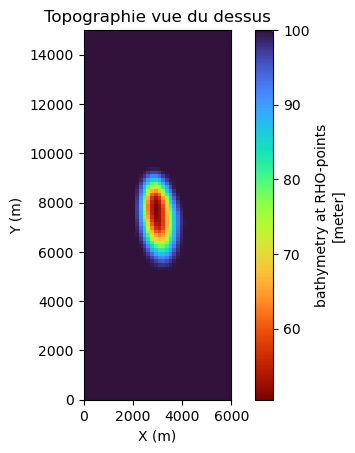

In [35]:
# Affichage de la topographie vue du dessus
fig, ax = plt.subplots()
fig.set_figwidth(6) 
ax.set_aspect('equal')
ds.h.plot(x="lon", y="lat", cmap="turbo_r", ax=ax)
# mesh = ax.pcolormesh(xplot, yplot, topographie_ellipse_fortran, cmap="turbo")
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
# ax.set_xlim(0,a_ellipse*2)
# ax.set_ylim(0,b_ellipse*2)
# plt.colorbar(ax=ax)
ax.set_title("Topographie vue du dessus")

In [22]:
%%time
print("min/max ssh=",ds.z_sfc.min().values,ds.z_sfc.max().values)
print("min/max u=",ds.xcur.min().values,ds.xcur.max().values)
print("min/max v=",ds.ycur.min().values,ds.ycur.max().values)
print("min/max u barotrope=",ds.xcur_btrope.min().values,ds.xcur_btrope.max().values)
print("min/max v barotrope=",ds.ycur_btrope.min().values,ds.ycur_btrope.max().values)

min/max ssh= -3.1287591 3.2062256
min/max u= -0.76460266 1.1181176
min/max v= -1.48228 1.9003491
min/max u barotrope= -0.55431926 0.43782172
min/max v barotrope= -1.4534345 1.4336742
CPU times: user 24.4 s, sys: 11.7 s, total: 36.1 s
Wall time: 54.2 s


Text(0.5, 1.0, 'ssh au milieu du domaine sur 12h')

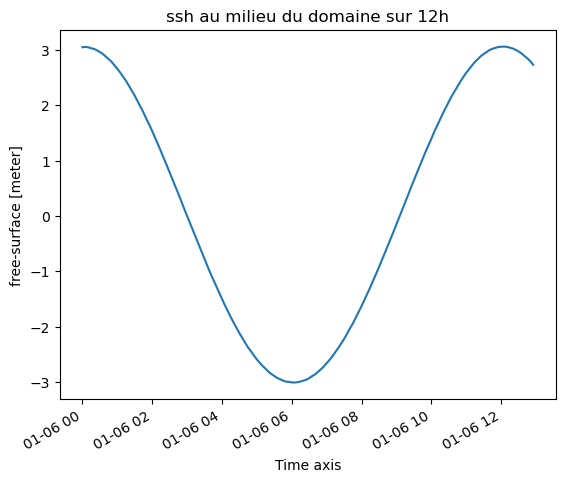

In [36]:
date1 = "1900-01-06T00"
date2 = "1900-01-06T12"
ds.z_sfc.isel(x=int(L/2),y=int(M/2)).sel(t=slice(date1,date2)).plot()
plt.title("ssh au milieu du domaine sur 12h")

Text(0.5, 1.0, 'ssh sur le bord sud')

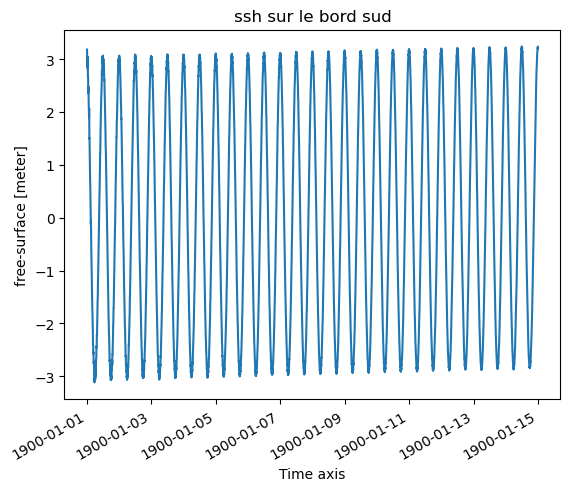

In [37]:
ds.z_sfc.isel(x=int(L/2),y=0).plot()
plt.title("ssh sur le bord sud")

Text(0.5, 1.0, 'ubar au milieu du domaine sur 12h')

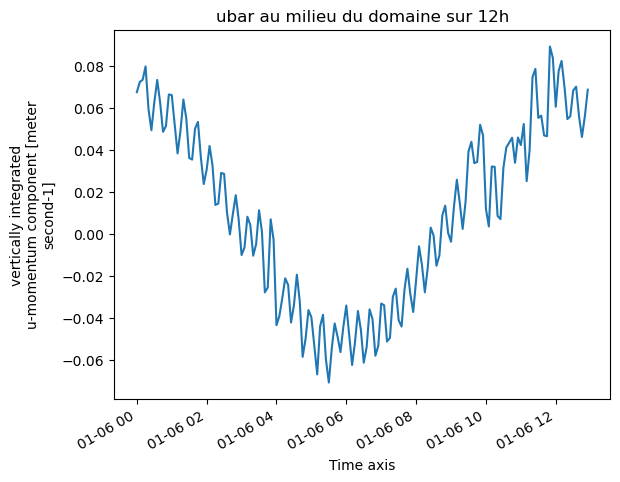

In [38]:

ds.xcur_btrope.isel(x_u=int(L/2),y=int(M/2)).sel(t=slice(date1,date2)).plot()
plt.title("ubar au milieu du domaine sur 12h")

Text(0.5, 1.0, 'ubar sur le bord sud')

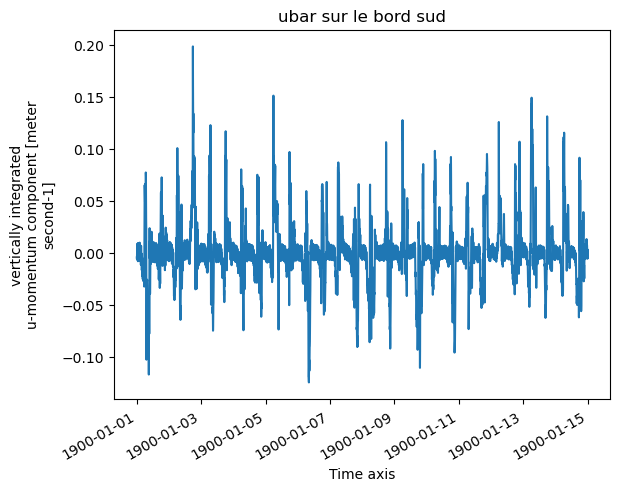

In [39]:

ds.xcur_btrope.isel(x_u=int(L/2),y=0).plot()
plt.title("ubar sur le bord sud")

Text(0.5, 1.0, 'vbar au milieu du domaine sur 12h')

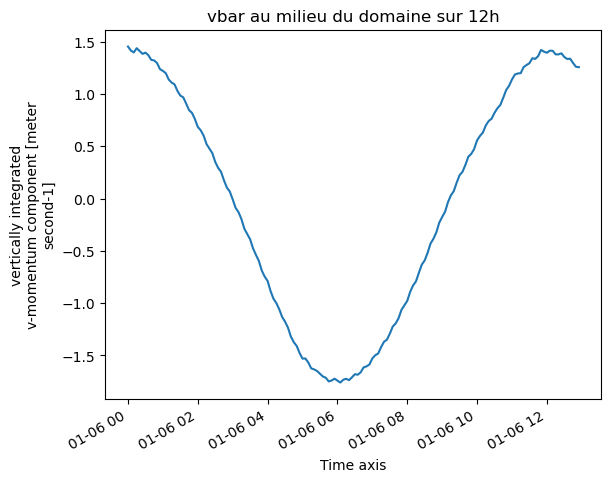

In [40]:

ds.ycur_btrope.isel(x=int(L/2),y_v=int(M/2)).sel(t=slice(date1,date2)).plot()
plt.title("vbar au milieu du domaine sur 12h")

Text(0.5, 1.0, 'vbar sur le bord sud')

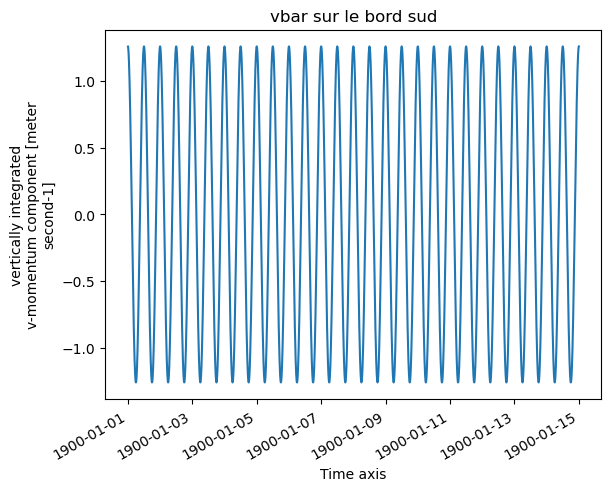

In [41]:

ds.ycur_btrope.isel(x=int(L/2),y_v=0).plot()
plt.title("vbar sur le bord sud")

Text(0.5, 1.0, 'Profil de v, t=1900-01-06T00,  x=xl/4, y=el/4')

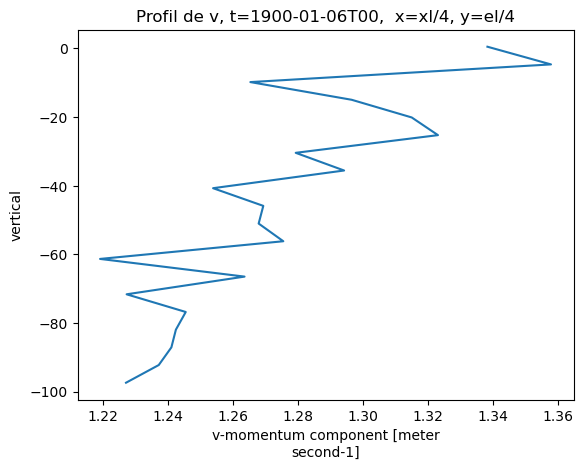

In [42]:
ds.ycur.isel(x=10,y_v=25).sel(t="1900-01-06T00",method="nearest").plot(y="z_v")
plt.title("Profil de v, t=1900-01-06T00,  x=xl/4, y=el/4")

CPU times: user 21.7 s, sys: 26.4 s, total: 48.1 s
Wall time: 23.7 s


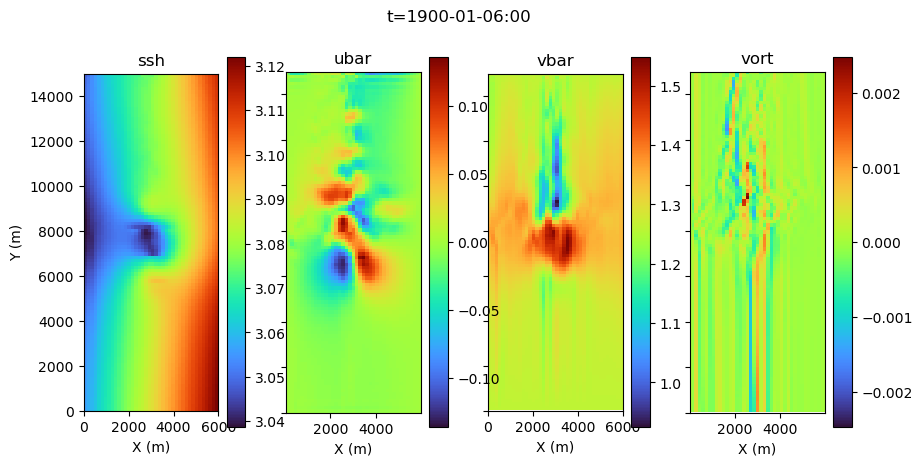

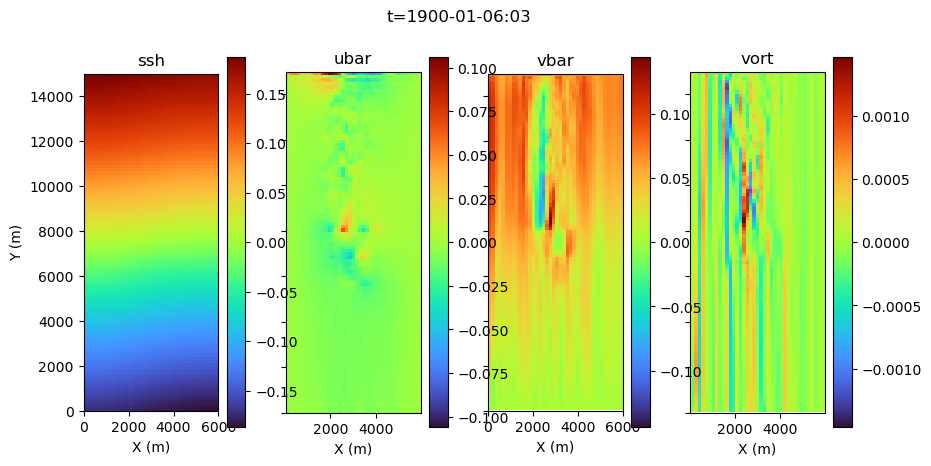

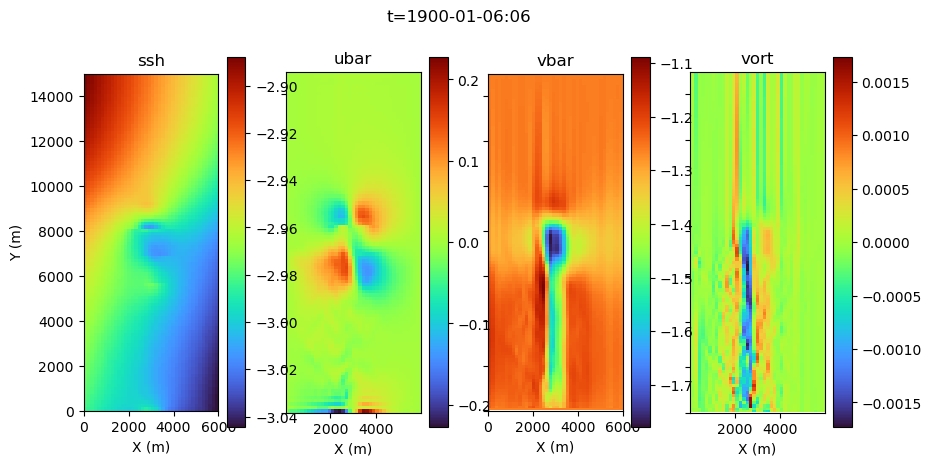

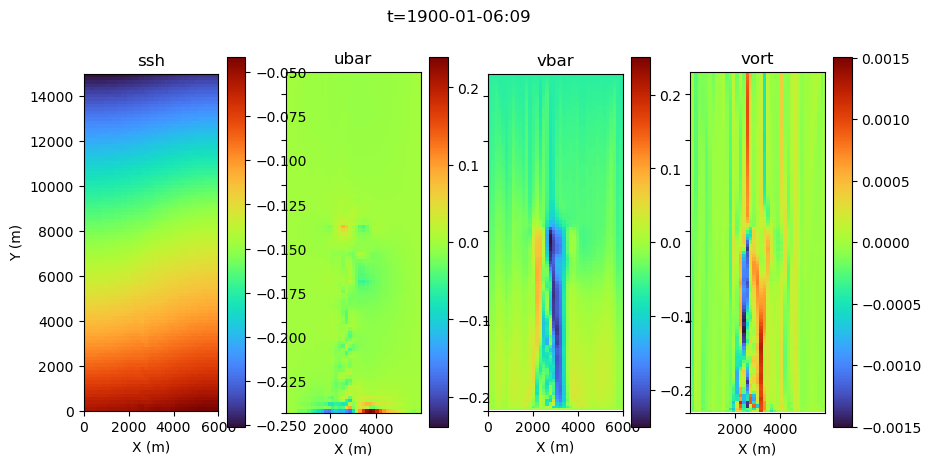

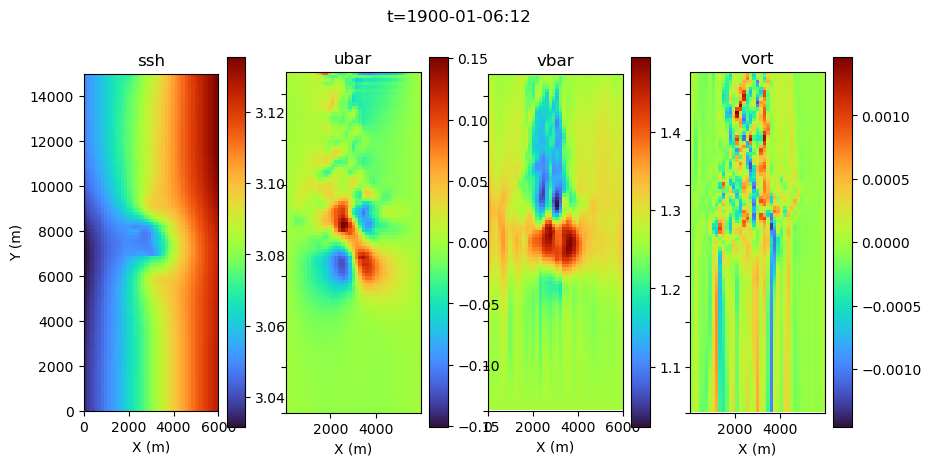

In [31]:
%%time
sdate = "1900-01-06T00"
edate = "1900-01-06T12"
freq = "3h"
dates = pd.date_range(sdate,edate,freq=freq)
titles = ["ssh", "ubar", "vbar", "vort"]

dsplot = ds.sel(t=dates, method="nearest")
xgplot = gop.fast_xgcm_grid(dsplot, grid_metrics=2)
vort = dg.relative_vorticity_sigma(dsplot.xcur, dsplot.ycur, xgplot, z=dsplot.z ).persist()
vort = vort.assign_coords({"lon_p":dsplot.lon_p, "lat_p":dsplot.lat_p})

for date in dates:
    fig, axes = plt.subplots(1,4,sharey = True)
    fig.set_figwidth(10) 
    for ax in axes:
        ax.set_aspect('equal')
    for ax in axes[1:]:
        ax.sharey(axes[0])
    dsplot.z_sfc.sel(t=date, method="nearest").plot(x="lon",y="lat",cmap="turbo",ax=axes[0],cbar_kwargs={'label': None})
    dsplot.xcur_btrope.sel(t=date, method="nearest").plot(x="lon_u",y="lat_u",cmap="turbo",ax=axes[1],cbar_kwargs={'label': None})
    dsplot.ycur_btrope.sel(t=date, method="nearest").plot(x="lon_v",y="lat_v",cmap="turbo",ax=axes[2],cbar_kwargs={'label': None})
    vort.isel(s_w=-1).sel(t=date, method="nearest").plot(x="lon_p",y="lat_p",cmap="turbo",ax=axes[3],cbar_kwargs={'label': None})
    
    for ax,title in zip(axes,titles):
        ax.set_xlabel('X (m)')
        ax.set(ylabel=None)
        ax.set_title(title)
    axes[0].set_ylabel('Y (m)')
    fig.suptitle('t='+date.strftime('%Y-%m-%d:%H'))

